This example tests whether an approach that uses empirical characteristic functions (ECFs) can detect differences in models with different parameters. 

In [1]:
from matplotlib import pyplot as plt
import ipywidgets as ipw
from IPython.display import display
import numpy as np
import pandas as pd

from stochastic_models import model_sir
from stochastic_tests import Test
import stochastic_repro as sr

pd.set_option('display.max_rows', None)

t_fin = 10.0
num_steps = 100
test_kwargs = dict(t_fin=t_fin, 
                   num_steps=num_steps, 
                   sample_times=[t_fin / num_steps * i for i in range(0, num_steps + 1)], 
                   trials=[100, 500, 1000, 5000, 10000])

beta1_mean = 2.0E-6
beta2_mean = 3.0E-6

test1 = Test(model=model_sir({'beta': ('norm', (beta1_mean, beta1_mean / 10))}), stochastic=False, **test_kwargs)
test2 = Test(model=model_sir({'beta': ('norm', (beta2_mean, beta2_mean / 10))}), stochastic=False, **test_kwargs)
tests = [test1, test2]

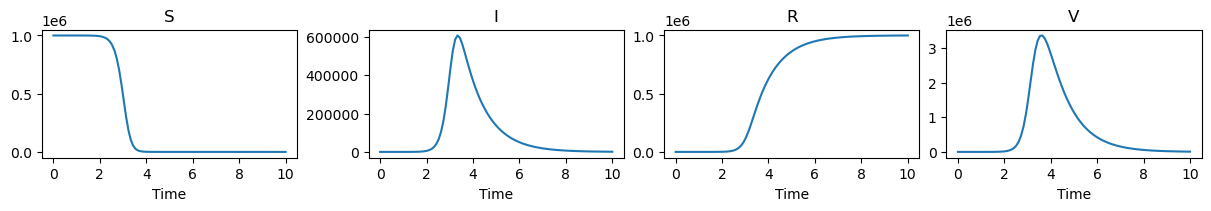

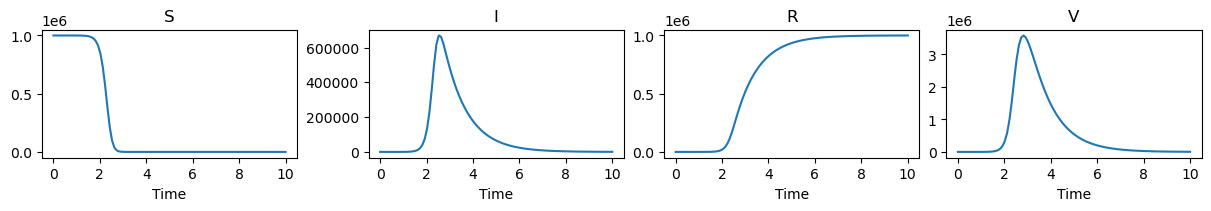

In [2]:
for test in tests:
    test.execute_deterministic()
    _ = test.plot_results_deterministic()

In [3]:
label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

for test in tests:
    test.execute_stochastic(label)
_ = out.clear_output()

Output()

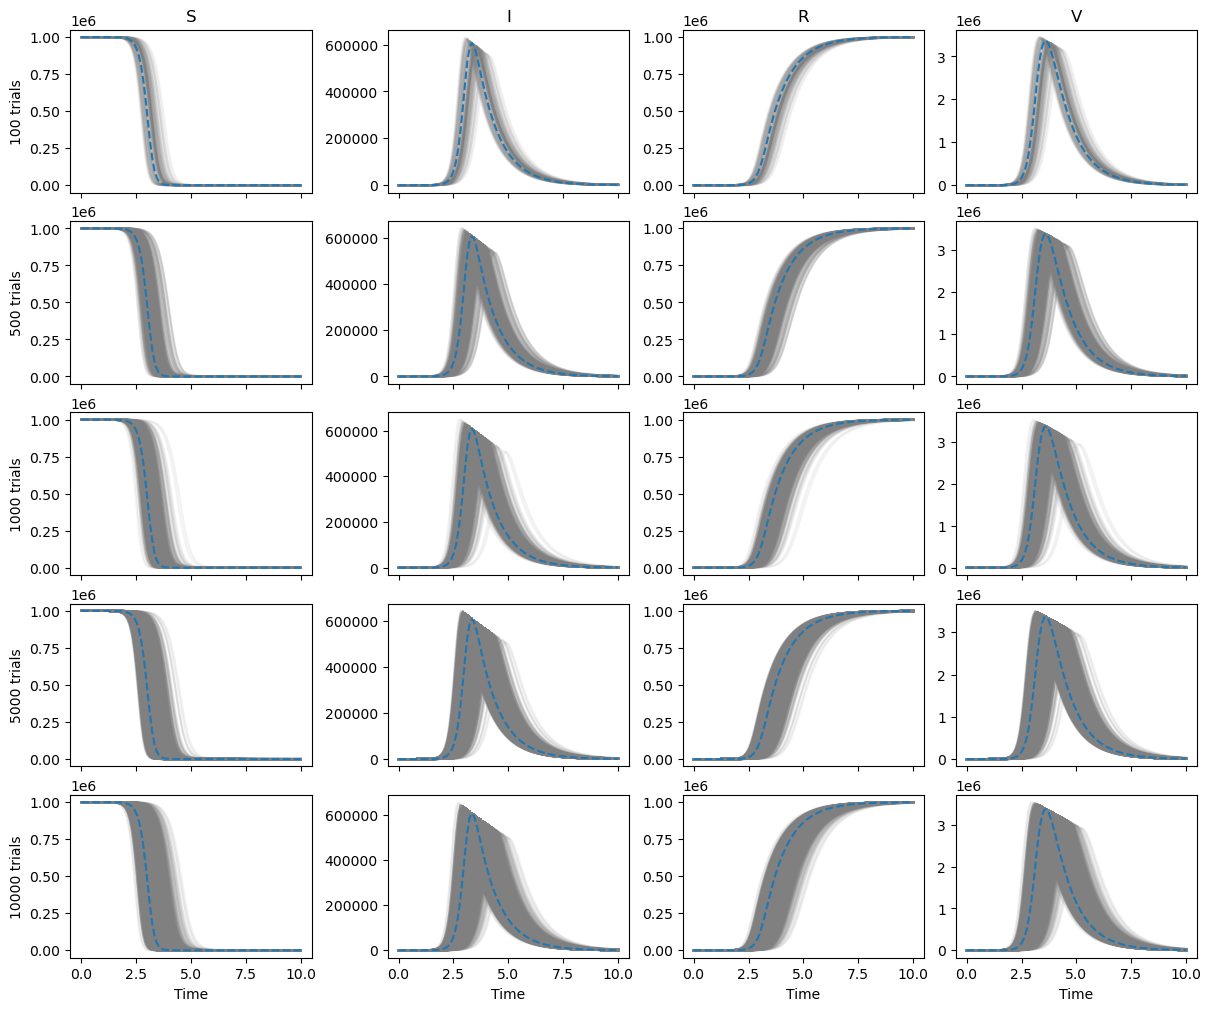

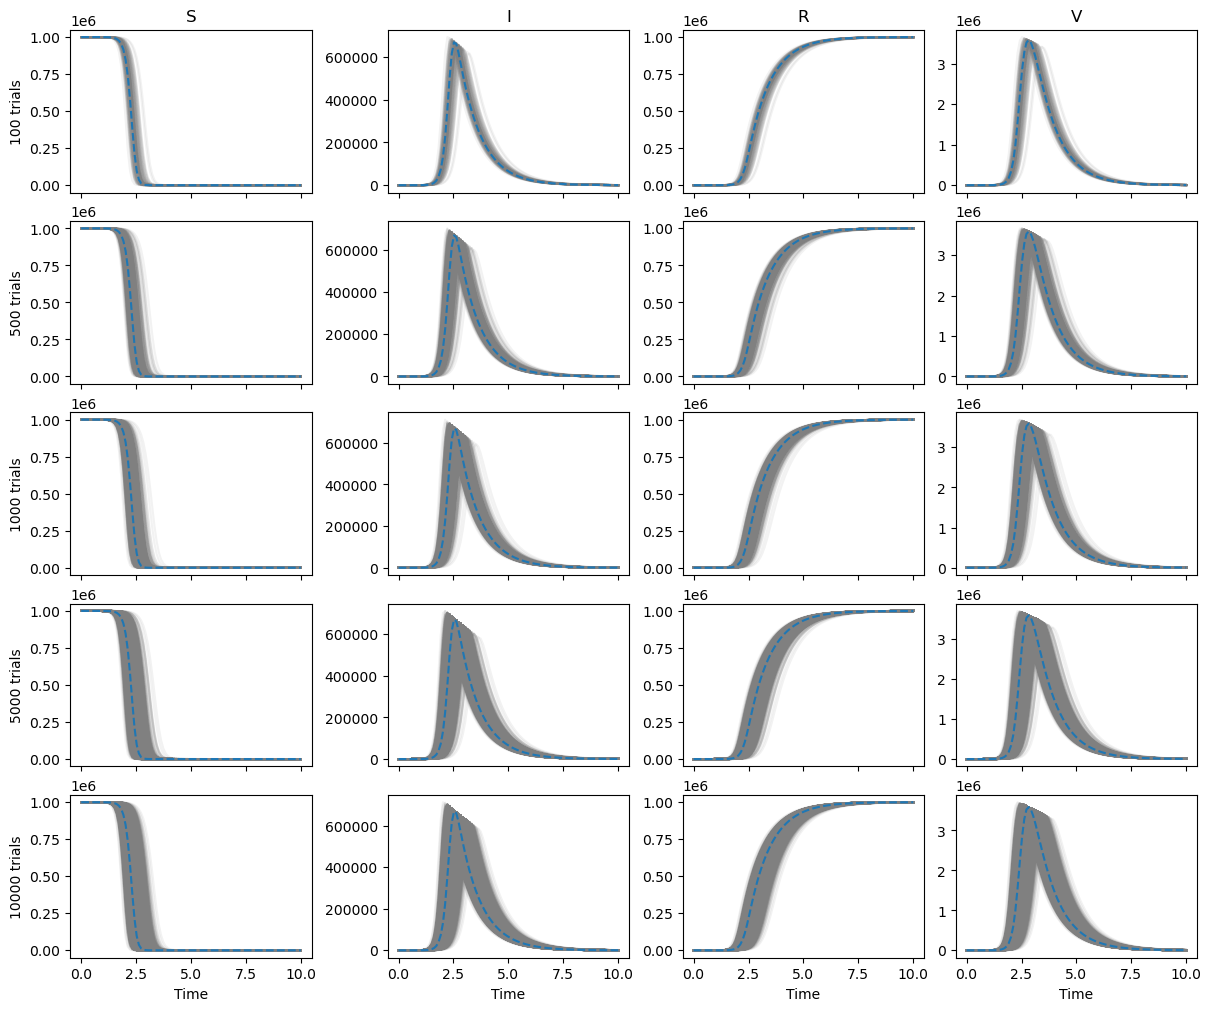

In [4]:
for test in tests:
    _ = test.plot_results_stochastic()

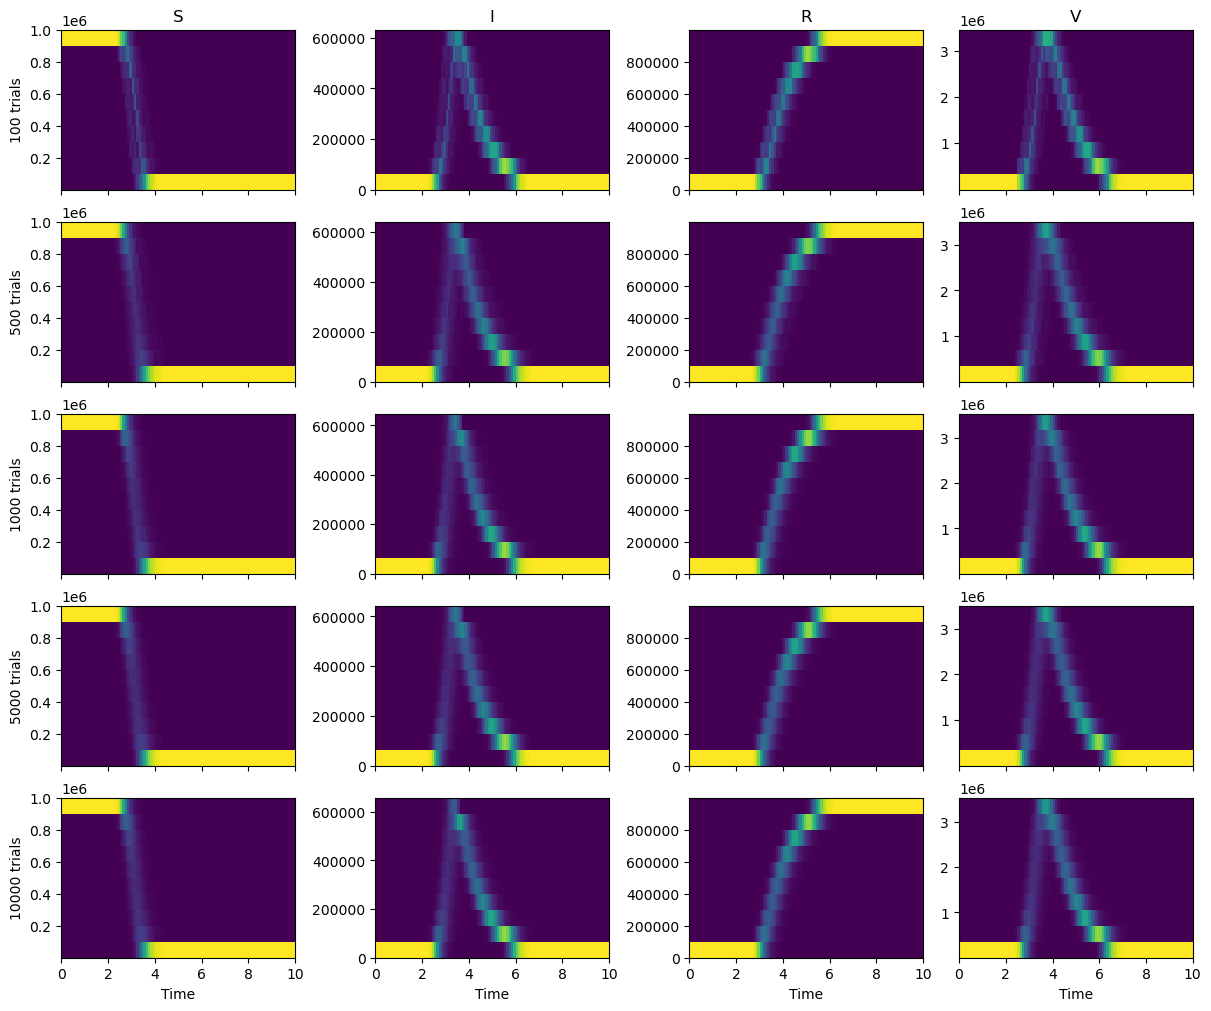

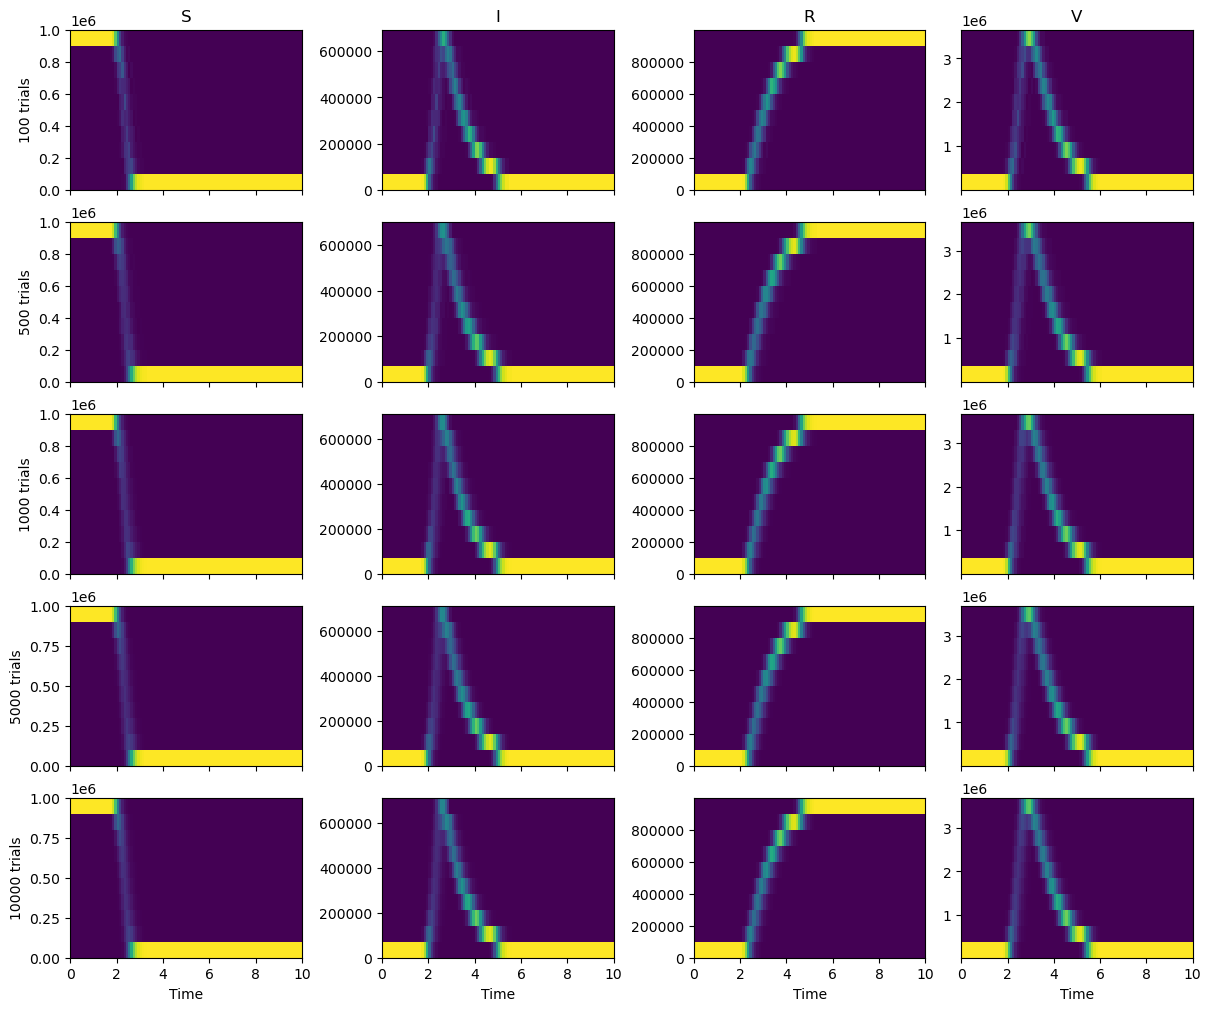

In [5]:
for test in tests:
    _ = test.plot_distributions()

/Users/timothy.sego/PycharmProjects/ssr_project_2024/code/stochastic_repro.py:992: OptimizeWarning: Covariance of the parameters could not be estimated
  return curve_fit(fit_func, data_x, data_y, **kwargs)


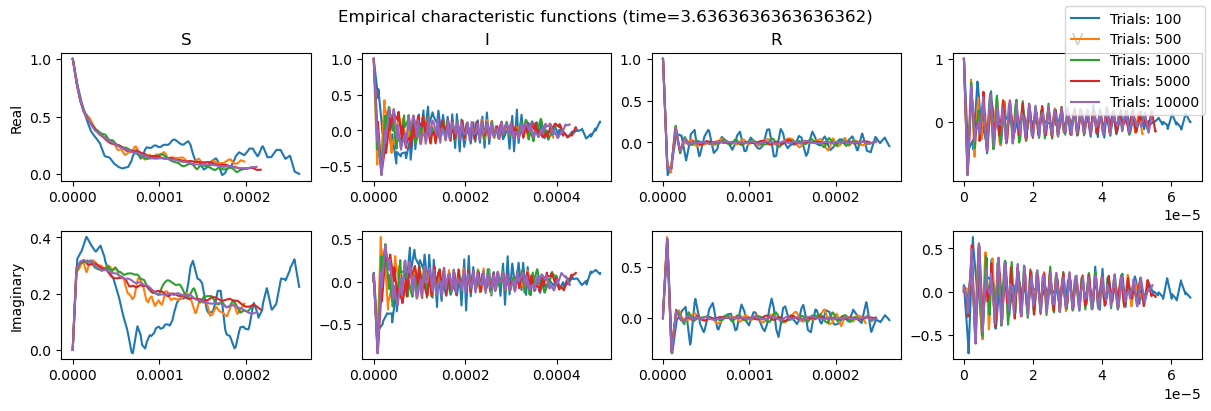

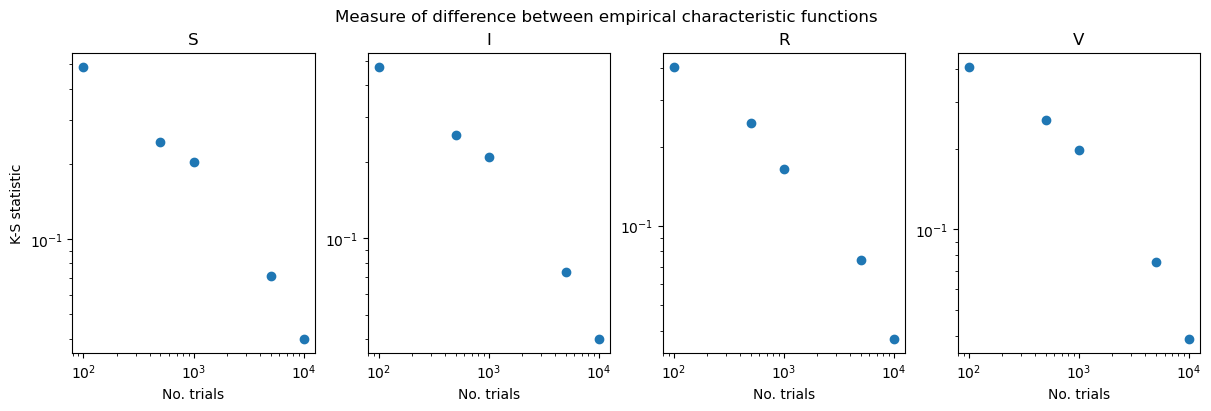

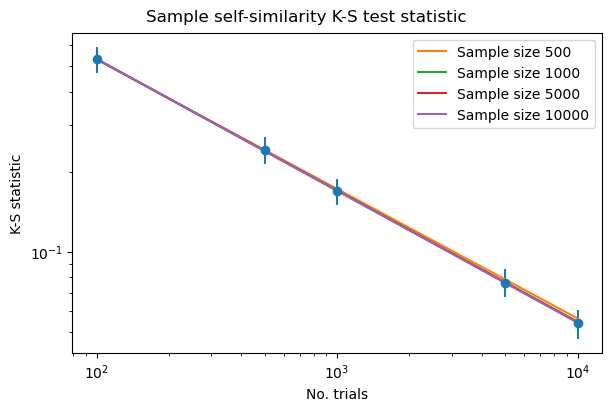

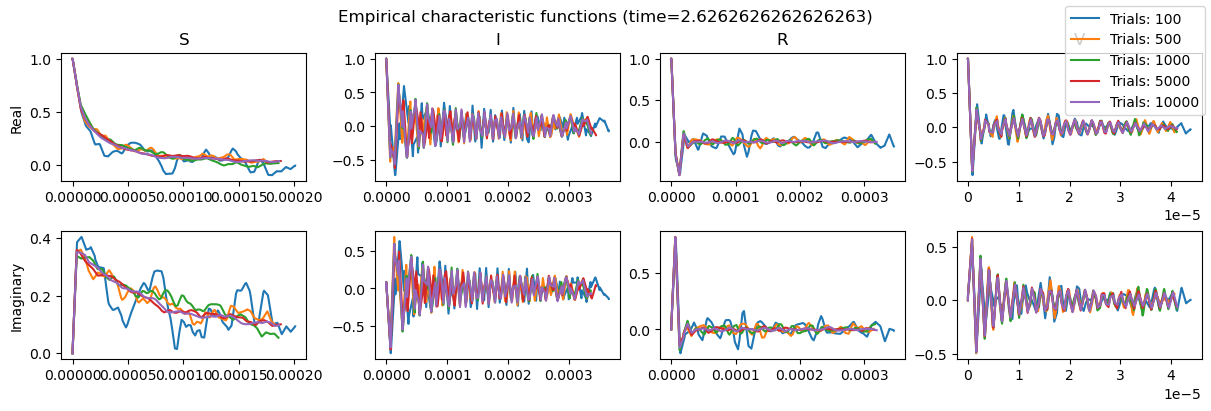

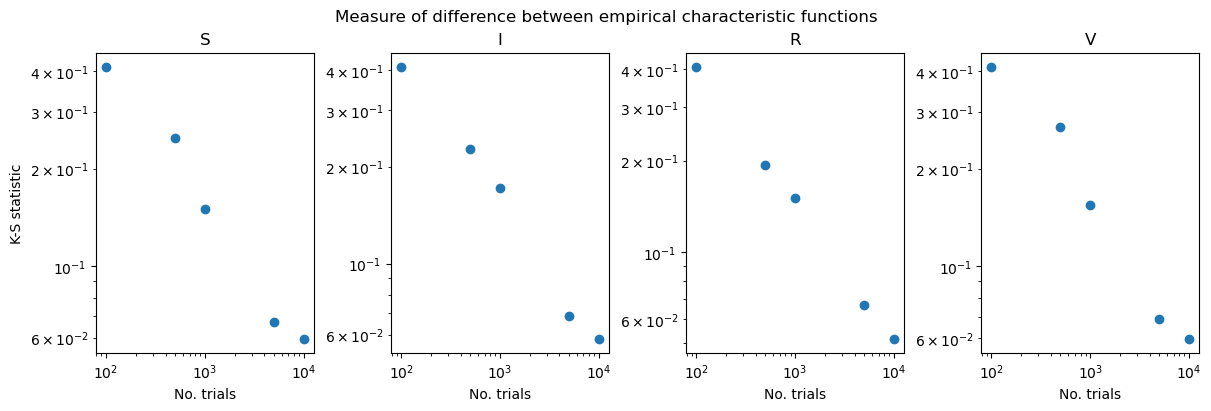

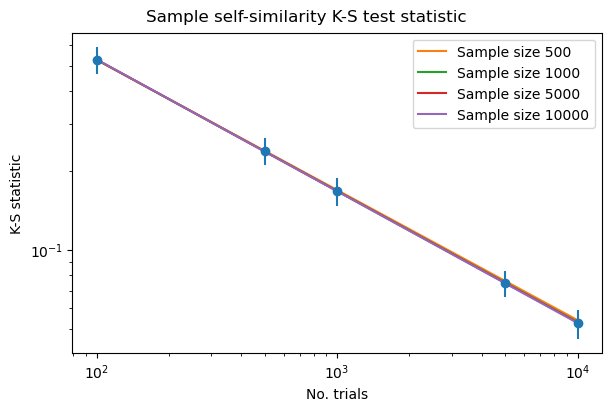

In [6]:
for test in [test1, test2]:
    test.find_ecfs()
    test.measure_ecf_diffs()
    test.plot_ecf(test.max_ks_stat_time(test.trials[-1]))
    test.plot_ecf_diffs()
    test.test_sampling(err_thresh=1E-3)
    test.generate_ecf_sampling_fits()
    _, ax = test.plot_ecf_sampling_fits(test.plot_ecf_sampling())
    _ = ax.legend()

Comparing the converged ECF of the two models, we should find that they are always quantifiably different since their models have different parameters.

Text(0.5, 0.98, 'Measure of empirical characteristic functions')

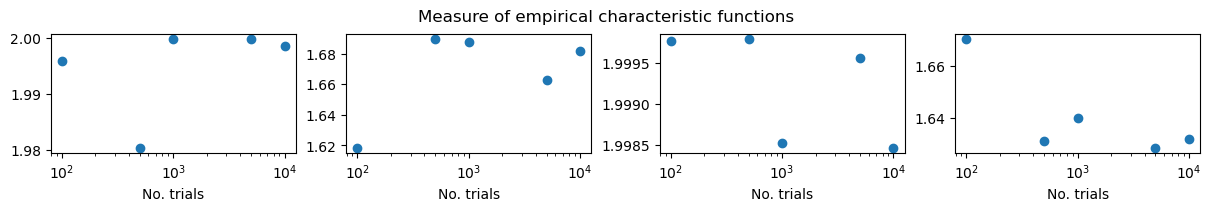

In [7]:
ecf_diff = sr.measure_ecf_diff_sets(test1.ecf, test2.ecf)

fig, ax = plt.subplots(1, len(test1.model.results_names), sharey=False, figsize=(12.0, 2.0), layout='compressed')
for i, name in enumerate(test1.model.results_names):
    ax[i].scatter(test1.trials, [max([el[name] for el in ecf_diff[trial]]) for trial in test1.trials])
    ax[i].set_xlabel('No. trials')
    ax[i].set_xscale('log')
fig.suptitle('Measure of empirical characteristic functions')

Testing for how well the method can detect differences in model parameters. 

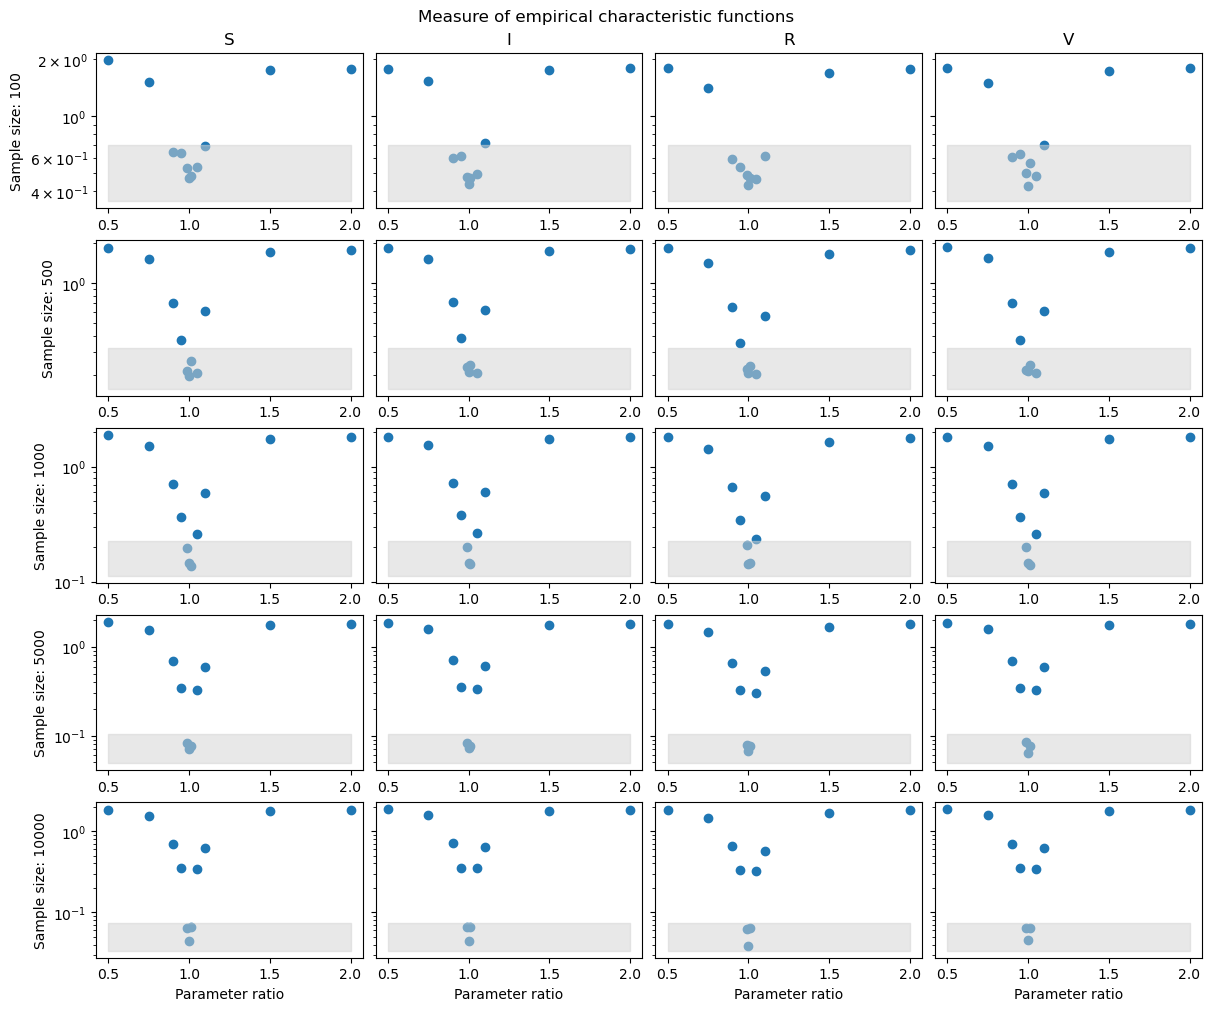

In [21]:
beta_fact = [0.5, 0.75, 0.9, 0.95, 0.99, 1.0, 1.01, 1.05, 1.1, 1.5, 2.0]
beta_comp = list()
test_test_kwargs = test_kwargs.copy()
test_test_kwargs['trials'] = [int(t / 2) for t in test_kwargs['trials']]

label, out = ipw.Label(), ipw.Output()
display(out)
with out:
    display(label)

# Make half-size tests
test1_sims_hs = {}
ecf_eval_info = {}
for trials in test1.trials:
    ht = int(trials / 2)
    simset = sr.SimSet(model=test1.model, num_trials=ht, stochastic=False, num_steps=test_kwargs['num_steps'], t_fin=test_kwargs['t_fin'])
    simset.results = {k: v[:ht, :] for k, v in test1.sims_s[trials].results.items()}
    simset.results_time = test1.sims_s[trials].results_time
    test1_sims_hs[ht] = simset
    ecf_eval_info[ht] = test1.ecf_eval_info[trials]
ecf1 = sr.generate_ecfs(test1_sims_hs, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)

for bf in beta_fact:
    label.value = f'Factor: {bf}...'

    betatest_mean = beta1_mean * bf
    test = Test(model=model_sir({'beta': ('norm', (betatest_mean, betatest_mean / 10))}), stochastic=False, **test_test_kwargs)
    test.execute_stochastic()
    ecf2 = sr.generate_ecfs(test.sims_s, test1.sample_times, test1.model.results_names, test_test_kwargs['trials'], ecf_eval_info)
    beta_comp.append(sr.measure_ecf_diff_sets(ecf1, ecf2))

out.clear_output()

fig, ax = plt.subplots(len(test1.trials), len(test1.model.results_names), sharey='row', figsize=(12.0, 2.0 * len(test1.trials)), layout='compressed')
for i, trial in enumerate(test1.trials):
    for j, name in enumerate(test1.model.results_names):
        ax[i][j].scatter(beta_fact, [max([el[name] for el in diff[int(trial / 2)]]) for diff in beta_comp])
        
        avg = np.average(test1.ks_stats_sampling[trial])
        err = np.std(test1.ks_stats_sampling[trial]) * 3
        ax[i][j].fill_between(beta_fact, avg - err, avg + err, color='lightgray', alpha=0.5)
        ax[i][j].set_yscale('log')

for i, name in enumerate(test1.model.results_names):
    ax[0][i].set_title(name)
    ax[-1][i].set_xlabel('Parameter ratio')
for i, trial in enumerate(test1.trials):
    ax[i][0].set_ylabel(f'Sample size: {trial}')
_ = fig.suptitle('Measure of empirical characteristic functions')

Report stats on detecting differences.

An upper bound on the probability of a false-positive when testing for reproducing results is calculated using Chebyshev's inequality with unknown population mean and variance. See equation 17 from 10.1007/s11222-011-9229-0. 

In [217]:
summary_entries = ['Average', 'St. dev.']
df_summary = pd.DataFrame(index=test_kwargs['trials'], columns=summary_entries)
eval_entries = ['Sample size', 'Scaling factor', 'Error', 'Standardized error', 'Acceptance p-value']
data_eval = []

for sample_size in test_test_kwargs['trials']:
    avg = np.average(test1.ks_stats_sampling[sample_size * 2])
    std = np.std(test1.ks_stats_sampling[sample_size * 2])
    df_summary.loc[sample_size * 2, 'Average'] = avg
    df_summary.loc[sample_size * 2, 'St. dev.'] = std

    err = [max([max(d.values()) for d in diff[sample_size]]) for diff in beta_comp]
    q2 = (sample_size + 1) / sample_size * np.var(test1.ks_stats_sampling[sample_size * 2], ddof=1)
    lam2 = [(e - avg) * (e - avg) / q2 for e in err]
    pr = [np.floor((sample_size + 1) / sample_size * ((sample_size - 1) / l2 + 1)) / (sample_size + 1) for l2 in lam2]
    for i in range(len(err)):
        if pr[i] > 1.0 or err[i] < avg:
            pr[i] = 1.0

    for i, bf in enumerate(beta_fact):
        data_eval.append((sample_size * 2, bf, err[i], (err[i] - avg) / std, min(1, pr[i])))

display(df_summary)
mi_eval = pd.MultiIndex.from_frame(pd.DataFrame(data_eval, columns=eval_entries))
df_eval = mi_eval.to_frame()
display(df_eval)

,Average,St. dev.
100,0.529438,0.05871
500,0.241481,0.027607
1000,0.168982,0.018963
5000,0.076462,0.009239
10000,0.053677,0.006621


Sample size  \
Sample size Scaling factor Error    Standardized error Acceptance p-value                
100         0.50           1.984710  24.787473         0.019608                    100   
            0.75           1.532647  17.087532         0.019608                    100   
            0.90           0.646299  1.990480          0.254902                    100   
            0.95           0.636569  1.824750          0.313725                    100   
            0.99           0.533264  0.065165          1.000000                    100   
            1.00           0.470108 -1.010561          1.000000                    100   
            1.01           0.564631  0.599438          1.000000                    100   
            1.05           0.537344  0.134651          1.000000                    100   
            1.10           0.724135  3.316244          0.098039                    100   
            1.50           1.756750  20.904662         0.019608                    100   
            2.00           1.808478  21.785729         0.019608                    100   
500         0.50           1.861523  58.681989         0.003984                    500   
            0.75           1.534309  46.829449         0.003984                    500   
            0.90           0.714033  17.117025         0.003984                    500   
            0.95           0.384770  5.190281          0.039841                    500   
            0.99           0.230237 -0.407312          1.000000                    500   
            1.00           0.214967 -0.960420          1.000000                    500   
            1.01           0.254660  0.477346          1.000000                    500   
            1.05           0.209049 -1.174796          1.000000                    500   
            1.10           0.624285  13.866115         0.007968                    500   
            1.50           1.735915  54.132129         0.003984                    500   
            2.00           1.842832  58.004949         0.003984                    500   
1000        0.50           1.908873  91.750206         0.001996                   1000   
            0.75           1.539802  72.287875         0.001996                   1000   
            0.90           0.726065  29.376816         0.001996                   1000   
            0.95           0.379256  11.088422         0.009980                   1000   
            0.99           0.206850  1.996907          0.251497                   1000   
            1.00           0.144751 -1.277798          1.000000                   1000   
            1.01           0.146743 -1.172751          1.000000                   1000   
            1.05           0.267646  5.202854          0.037924                   1000   
            1.10           0.607546  23.126916         0.001996                   1000   
            1.50           1.752404  83.499063         0.001996                   1000   
            2.00           1.835975  87.906033         0.001996                   1000   
5000        0.50           1.897515  197.101863        0.000400                   5000   
            0.75           1.583824  163.149472        0.000400                   5000   
            0.90           0.704341  67.958523         0.000400                   5000   
            0.95           0.349905  29.596071         0.001200                   5000   
            0.99           0.084851  0.907964          1.000000                   5000   
            1.00           0.073369 -0.334764          1.000000                   5000   
            1.01           0.077096  0.068637          1.000000                   5000   
            1.05           0.333341  27.803252         0.001599                   5000   
            1.10           0.612279  57.994212         0.000400                   5000   
            1.50           1.759986  182.216347        0.000400                   5000   
            2.00         